<a href="https://colab.research.google.com/github/Mohd6288/AI/blob/main/ddpm_jellyFish800_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Data link](https://) https://drive.google.com/file/d/1UN-Uwl8yQQgVQ-lfRbpvxnQCmfD-QTJg/view?usp=sharing

[data ID] 1UN-Uwl8yQQgVQ-lfRbpvxnQCmfD-QTJg

[Data reference link] https://www.kaggle.com/datasets/anshtanwar/jellyfish-types


```
!gdown --id 1UN-Uwl8yQQgVQ-lfRbpvxnQCmfD-QTJg
!unzip allJullyImags.zip -d allJullyImags
```


!gdown --id 1UN-Uwl8yQQgVQ-lfRbpvxnQCmfD-QTJg

---
!unzip allJullyImags.zip -d allJullyImags
---



```
# !mv allJullyImags/allJullyImags/* allJullyImags/
# clean if you wish :)
# !rm -rf allJullyImags/allJullyImags/
# !rm allJullyImags.zip
```



In [3]:
#Use me
# !gdown --id 1UN-Uwl8yQQgVQ-lfRbpvxnQCmfD-QTJg
# !unzip allJullyImags.zip -d allJullyImags
# !mv allJullyImags/allJullyImags/* allJullyImags/
# !rm -rf allJullyImags/allJullyImags/
# !rm allJullyImags.zip
# https://drive.google.com/file/d/1uwCVxnricUZX6DRJ-cXTWGXEHUghuwZT/view?usp=sharing
!gdown --id 1uwCVxnricUZX6DRJ-cXTWGXEHUghuwZT
# !unzip allJullyImags.zip -d allJullyImags
!unzip ddpm.models.zip -d ddpm.models

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1uwCVxnricUZX6DRJ-cXTWGXEHUghuwZT
From (redirected): https://drive.google.com/uc?id=1uwCVxnricUZX6DRJ-cXTWGXEHUghuwZT&confirm=t&uuid=845b10f0-5164-45d9-a299-62d727e22900
To: /content/ddpm.models.zip
100% 934M/934M [00:06<00:00, 144MB/s]
Archive:  ddpm.models.zip
  inflating: ddpm.models/models/ddpm.weights.h5  


# ⚛ Jellyfish Image Dataset ⚛


#Setup

In [5]:
import math
import tqdm
import pathlib

import numpy as np
import matplotlib.pyplot as plt

# Requires TensorFlow >=2.11 for the GroupNormalization layer.
import tensorflow as tf
import tensorflow_datasets as tfds

Hyperparameters

In [27]:
batch_size = 64
num_epochs = 400  # This takes ~1h on an A100
total_timesteps = 1000
norm_groups = 8  # Number of groups used in GroupNormalization layer
learning_rate = 2e-4

# batch_size = 128  # Increased for faster training
# num_epochs = 50  # Reduced for quicker training
# total_timesteps = 500  # Reduced timesteps for faster convergence
# norm_groups = 8  # Retained, suitable for GroupNormalization
# learning_rate = 5e-4  # Slightly higher learning rate for faster convergence

img_size = 128
img_channels = 3
clip_min = -1.0
clip_max = 1.0

first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks = 2  # Number of residual blocks

dataset_name = "Jullyfish"
dataset_path = "/content/allJullyImags/*.jpg"
splits = ["train"]

Data & Augmentation

In [28]:
train_ds = tf.data.Dataset.list_files(str(dataset_path), shuffle=True)

def augment(img):
    """Flips an image left/right randomly."""
    return tf.image.random_flip_left_right(img)

def resize_and_rescale(img, size):
    """Resize the image to the desired size first and then
    rescale the pixel values in the range [-1.0, 1.0].

    Args:
        img: Image tensor
        size: Desired image size for resizing
    Returns:
        Resized and rescaled image tensor
    """
    clip_min = -1.0
    clip_max = 1.0

    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    crop_size = tf.minimum(height, width)

    img = tf.image.crop_to_bounding_box(
        img,
        (height - crop_size) // 2, # top left corner (x & y)
        (width - crop_size) // 2,  # get half of the remainder, i.e. 'margins')
        crop_size,                 # width
        crop_size,                 # height
    )

    # Resize
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, size=size, antialias=True)

    # Rescale the pixel values
    img = img / 127.5 - 1.0
    img = tf.clip_by_value(img, clip_min, clip_max)
    return img

def train_preprocessing(file_path):
    # Load the image from the file path
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Adjust channels if needed
    img = resize_and_rescale(img, size=(img_size, img_size))
    img = augment(img)
    return img



# Apply transformations
train_ds = (
    train_ds.map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .shuffle(batch_size * 2)
    .prefetch(tf.data.AUTOTUNE)
)


In [29]:
train_ds

<_PrefetchDataset element_spec=TensorSpec(shape=(64, 128, 128, 3), dtype=tf.float32, name=None)>

In [30]:
def plot_images(images, num_rows=2, num_cols=8, figsize=(12, 5)):

    assert len(images) <= num_rows * num_cols, f"Too many images ({len(images)}) for {num_rows} rows x {num_cols} cols ({num_rows * num_cols} slots): please increase either the rows or the columns!"

    # from [-1,1] to [0,255]
    images = tf.clip_by_value(images * 127.5 + 127.5, 0.0, 255.0).numpy().astype(np.uint8)

    _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    # turn off all axes no matter how many images we have
    [a.axis("off") for row in ax for a in row]
    # display images
    for i, image in enumerate(images):
        if num_rows == 1: # if only one row
            ax[i].imshow(image)
        else:
            ax[i // num_cols, i % num_cols].imshow(image)

    plt.tight_layout()
    plt.show()

for batch in train_ds.take(1):
    print(batch[:16])

tf.Tensor(
[[[[-0.998259   -0.5764705  -0.02745086]
   [-0.9947656  -0.57123613 -0.02221644]
   [-0.9786625  -0.555133   -0.00611329]
   ...
   [-1.         -0.3708982   0.14034581]
   [-1.         -0.372842    0.14480507]
   [-0.9773098  -0.33328778  0.18435931]]

  [[-0.9985539  -0.581705   -0.041381  ]
   [-0.9956522  -0.5764705  -0.03614658]
   [-0.98931575 -0.5701341  -0.02981007]
   ...
   [-0.9972332  -0.3655458   0.14569807]
   [-1.         -0.36470586  0.15294123]
   [-0.98139495 -0.3414353   0.17621183]]

  [[-0.99597925 -0.583117   -0.05260772]
   [-0.9907448  -0.5778825  -0.04737329]
   [-0.99622655 -0.5845171  -0.05400771]
   ...
   [-0.9950089  -0.36461294  0.14663112]
   [-1.         -0.36969686  0.14795017]
   [-0.97811985 -0.3444857   0.1731615 ]]

  ...

  [[-0.9931179  -0.61472833 -0.03903711]
   [-0.99215686 -0.6128062  -0.04666018]
   [-0.9933325  -0.61424106 -0.04809505]
   ...
   [-0.9981673  -0.51024413  0.10823894]
   [-1.         -0.51318276  0.10504103]
   [-

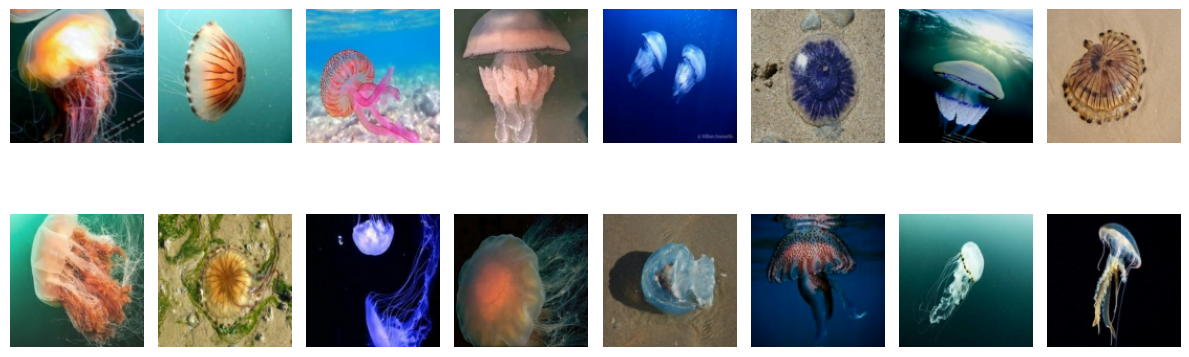

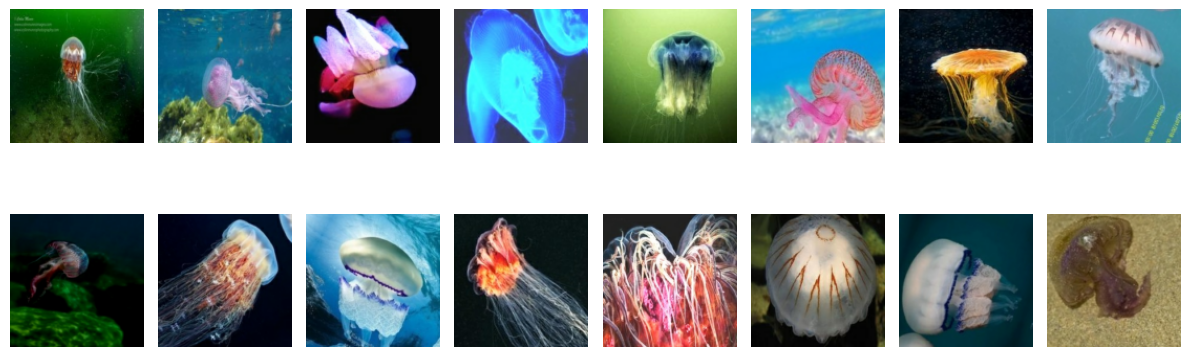

In [31]:
# Extract images from a batch in train_ds and plot them
for batch in train_ds.take(2):  # Take the first batch
    # Flatten the batch to get individual images
    images_to_plot = batch[:16]  # Select the first 16 images
    plot_images(images_to_plot, num_rows=2, num_cols=8)


The Gaussian Diffusion class

In [32]:
class GaussianDiffusion:
    """Gaussian diffusion utility.

    Note:
        q refers to the forward process (noising, fixed)
        p refers to the reversed process (denoising, learnt)
        In the docstrings, B: batch_size, W: width, H: height, C: channels

    Args:
        beta_start: Start value of the scheduled variance
        beta_end: End value of the scheduled variance
        timesteps: Number of time steps in the forward process
    """

    def __init__(
        self,
        beta_start=1e-4,
        beta_end=0.02,
        timesteps=1000,
        clip_min=-1.0,
        clip_max=1.0,
    ):

        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        self.num_timesteps = int(timesteps)

        # ----------------------------------------------------------------------
        # PRECOMPUTED VALUES (at all time steps)
        # for diffusion q(x_t | x_{t-1}) and others

        def tf_const(x):
            return tf.constant(x, dtype=tf.float32)

        # Linear variance schedule (float64 for better precision)
        self.betas = betas = np.linspace(beta_start, beta_end, timesteps, dtype=np.float64)
        self.betas = tf_const(betas)

        alphas = 1.0 - betas

        # alphas_bar_t
        alphas_cumprod = np.cumprod(alphas, axis=0)
        self.alphas_cumprod = tf_const(alphas_cumprod)

        # alphas_bar_t-1
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
        self.alphas_cumprod_prev = tf_const(alphas_cumprod_prev)

        # sqrt(alphas_bar) | used in `q_sample`
        self.sqrt_alphas_cumprod = tf_const(np.sqrt(alphas_cumprod))

        # sqrt(1 - alphas bar) | used in `q_sample`
        self.sqrt_one_minus_alphas_cumprod = tf_const(np.sqrt(1.0 - alphas_cumprod))

        # sqrt(1/alphas_bar) | used in `p_sample`
        self.sqrt_recip_alphas_cumprod = tf_const(np.sqrt(1.0 / alphas_cumprod))

        # sqrt(1/alphas_bar - 1) | `used in p_sample`
        self.sqrt_recipm1_alphas_cumprod = tf_const(np.sqrt(1.0 / alphas_cumprod - 1))

        # ----------------------------------------------------------------------
        # VARIANCE (fixed / available in closed form!)

        #  2 eq. (7) | betas_tilde_t (= sigma**2) | calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod))
        self.posterior_variance = tf_const(posterior_variance)

        # Log calculation clipped because the posterior variance is 0 at the
        # beginning of the diffusion chain | used in `p_sample`
        self.posterior_log_variance_clipped = tf_const(np.log(np.maximum(posterior_variance, 1e-20)))

        # ----------------------------------------------------------------------
        # MEAN (learnt, coefficient only) | both used in `p_sample`

        # 2 eq. (7) | coef1 * x_0 | sqrt(alphas_bar_t-1) * betas / (1 - alphas_bar))
        self.posterior_mean_coef1 = tf_const(np.sqrt(alphas_cumprod_prev) * betas / (1.0 - alphas_cumprod))

        # 2 eq. (7) | coef2 * x_t | sqrt(alphas) * (1 - alphas_bar_t-1) / (1 - alphas_bar)
        self.posterior_mean_coef2 = tf_const(np.sqrt(alphas) * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod))

    # --------------------------------------------------------------------------
    # UTIL: extract precomputed values at various timesteps

    def _extract(self, a, t, x_shape, verbose=False):
        """
        Extract some coefficients at specified timesteps, then reshape to
        (B, 1, 1, 1) (data: (B, W, H, C)) for broadcasting.

        Args:
            a (T,): Tensor to extract from
            t (B,): Timestep for which the coefficients are to be extracted
            x_shape (B, W, H, C): Shape of the current batched samples

        Returns:
            out, (B, 1, 1, 1): Extracted tensor
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        if verbose: print(f"out shape: {out.shape=}")
        return tf.reshape(out, [batch_size, 1, 1, 1])

    # --------------------------------------------------------------------------
    # TRAINING: generate noisy samples

    def q_sample(self, x_0, t, noise):
        """
        Diffuse the data | 3.2 Algorithm 1:
            sqrt(alphas_bar) * x_0 + sqrt(1 - alphas_bar) * noise

        Args:
            x_0 (B, W, H, C): Initial batch of samples (before the 1st diffusion step)
            t (B): Current timestep
            noise (B, W, H, C): Gaussian noise to be added at the current timestep

        Returns:
            (B, W, H, C): Diffused samples at timestep `t`

        Note:
            Used by `DiffusionModel` in `train_step`, step 4
        """
        x_0_shape = tf.shape(x_0)
        # coef1: sqrt(alphas_bar), coef2: sqrt(1 - alphas_bar)
        coef1 = self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_0))
        coef2 = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_0_shape)
        # mix x_0 with gaussian noise
        return coef1 * x_0 + coef2 * noise

    # --------------------------------------------------------------------------
    # SAMPLING: use noisy samples (x_t) to predict the noise and remove it

    def p_sample(self, pred_noise, x_t, t, clip_denoised=True):

        x_t_shape = tf.shape(x_t)

        # 1. `p_mean_variance`: reconstruct x_0 from noisy sample and noise prediction
        #    3.2 Algorithm 2 | Compute the mean of the reconstructed (denoised) sample:
        #    [coef1: sqrt(1/alphas_bar_t)] * x_t - [coef2: sqrt(1/alphas_bar - 1)] * pred_noise

        coef1 = self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape)
        coef2 = self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape)
        x_0_reconstructed = coef1 * x_t - coef2 * pred_noise

        # 2. clip
        if clip_denoised:
            x_0_reconstructed = tf.clip_by_value(x_0_reconstructed, self.clip_min, self.clip_max)

        # 3. `q_posterior`
        #     2 eq. (7) | Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
        #     coef1 (* x_0) | sqrt(alphas_bar_t-1) * betas / (1 - alphas_bar))
        #     coef2 (* x_t) | sqrt(alphas) * (1 - alphas_bar_t-1) / (1 - alphas_bar)

        coef1 = self._extract(self.posterior_mean_coef1, t, x_t_shape)
        coef2 = self._extract(self.posterior_mean_coef2, t, x_t_shape)
        # compute mean: mu_tilde_t(x_t, x_0)
        model_mean = coef1 * x_0_reconstructed + coef2 * x_t

        # extract precomputed variance (our sigma, for sigma z):
        # beta_tilde_t = betas * (1 - alphas_bar_t-1) / (1 - alphas_bar)
        model_log_variance = self._extract(self.posterior_log_variance_clipped, t, x_t_shape)

        # reinject some noise (Langevin dynamics)
        noise = tf.random.normal(shape=x_t.shape, dtype=x_t.dtype)

        # no noise when t == 0
        # (if t == 0, the mask is zero, removing tf.exp... * noise below)
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x_t)[0], 1, 1, 1]
        )

        # mu + mask * sqrt(var) (= sigma) * noise
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

In [33]:
gfd = GaussianDiffusion(timesteps=total_timesteps)
print(f"{gfd.timesteps} timesteps")
print(f"Betas ranging from:           {gfd.beta_start}            to {gfd.beta_end}")
print(f"Alphas bar t ranging from     {gfd.alphas_cumprod[0].numpy():.15f} to {gfd.alphas_cumprod[-1].numpy():.15f}")
print(f"Alphas bar t - 1 ranging from {gfd.alphas_cumprod_prev[0].numpy():.15f} to {gfd.alphas_cumprod_prev[-1].numpy():.15f}")

1000 timesteps
Betas ranging from:           0.0001            to 0.02
Alphas bar t ranging from     0.999899983406067 to 0.000040358296246
Alphas bar t - 1 ranging from 1.000000000000000 to 0.000041181934648


In [34]:
for batch in train_ds.take(1):

    # work on a tiny batch
    n = 3
    b = batch[:n]

    # fake timesteps (not randomly sampled), to guarantee
    # we have at least one zero
    t = tf.range(n)

    nonzero_mask = tf.reshape(
        1 - tf.cast(tf.equal(t, 0), tf.float32), [n, 1, 1, 1]
    )

    print(f"batch shape:         {b.shape}")
    print()
    print(f"t, shape:            {t.shape}")
    print(t)
    print()
    print(f"nonzero mask, shape: {nonzero_mask.shape}")
    print("the nonzero mask is one for t > 0, zero otherwise:")
    print()
    print(nonzero_mask)

batch shape:         (3, 128, 128, 3)

t, shape:            (3,)
tf.Tensor([0 1 2], shape=(3,), dtype=int32)

nonzero mask, shape: (3, 1, 1, 1)
the nonzero mask is one for t > 0, zero otherwise:

tf.Tensor(
[[[[0.]]]


 [[[1.]]]


 [[[1.]]]], shape=(3, 1, 1, 1), dtype=float32)


In [35]:
# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return tf.keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )

##Time Embeding##

In [36]:
class TimeEmbedding(tf.keras.layers.Layer):
    """
    A Layer creating Time Embedding tensors.

    Attributes:
        dim: the dimension of (output) embedding space (D)
    """
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        """
        Args:
            inputs: a tensor, e.g. of time steps, shape: (T,)

        Returns:
            emb: a tensor of embedding, shape: (T, D) # D: embedding dim
        """
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

In [37]:
# random timesteps
t = tf.range(100, dtype=tf.int64)
print(f"max timestep: {total_timesteps}, batch size: {batch_size}")
print()
print(f"timesteps tensor, shape: {t.shape}")
print(t)
print()

temb = TimeEmbedding(dim=first_conv_channels * 4)(t)

print(f"embedding dim: {first_conv_channels * 4}")
print()
print(f"time embeddings tensor, shape: {temb.shape}")
print(temb)

max timestep: 1000, batch size: 64

timesteps tensor, shape: (100,)
tf.Tensor(
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99], shape=(100,), dtype=int64)

embedding dim: 256

time embeddings tensor, shape: (100, 256)
tf.Tensor(
[[ 0.          0.          0.         ...  1.          1.
   1.        ]
 [ 0.841471    0.80164677  0.7610847  ...  1.          1.
   1.        ]
 [ 0.90929747  0.95844567  0.98735905 ...  1.          1.
   1.        ]
 ...
 [ 0.37960774  0.7782232   0.79535306 ...  0.9999371   0.99994564
   0.999953  ]
 [-0.57338184 -0.0382053   0.05458004 ...  0.9999358   0.9999445
   0.99995196]
 [-0.99920684 -0.82390124 -0.724546   ...  0.9999345   0.9999434
   0.999951  ]], shape=(100, 256), dtype=float32)


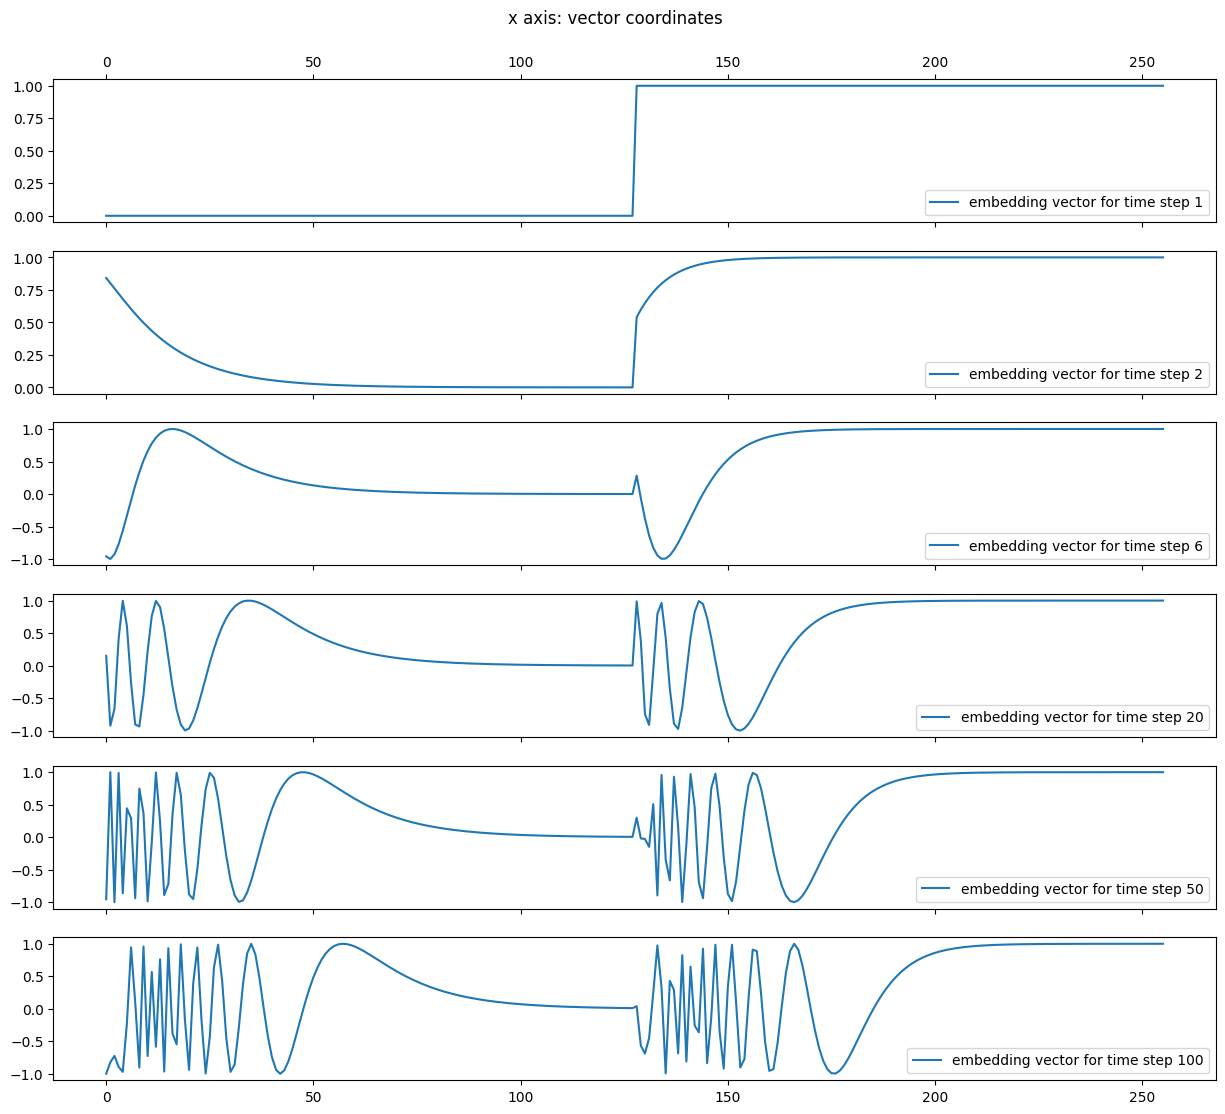

In [38]:
fig, axs = plt.subplots(6,1,figsize=(15,13), sharex=True)

r = tf.range(temb.shape[1])
# choosing arbitrarily a few time steps here ↓
for i, (ax, step) in enumerate(zip(axs, (0,1,5,19, 49, 99))):
    if i == 0: # additional ticks for the top subplot
        ax.tick_params(labelbottom=False, top=True, labeltop=True)
    ax.plot(r, temb[step], label=f"embedding vector for time step {step+1}")
    ax.legend(loc="lower right")
fig.supxlabel("x axis: vector coordinates", y=.92)
fig.show()

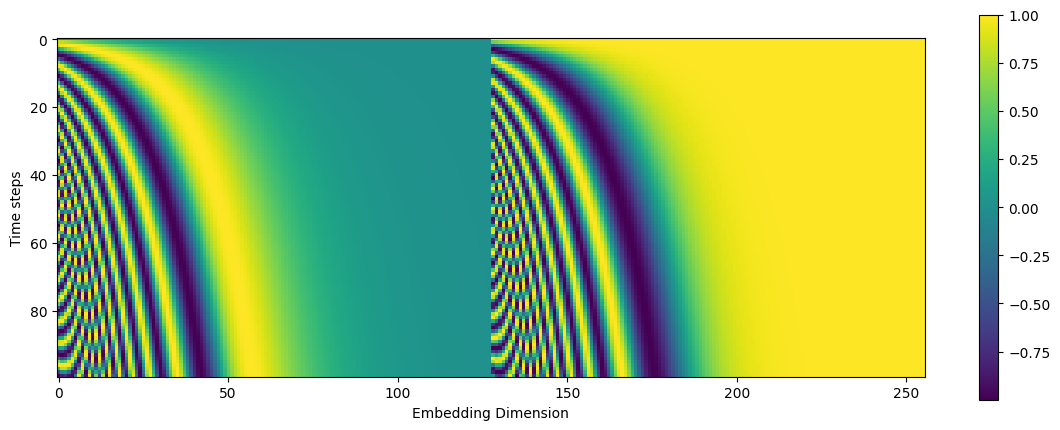

In [19]:
fig, ax = plt.subplots(figsize=(14, 5))
cax = ax.matshow(temb)
ax.set_xlabel("Embedding Dimension")
ax.xaxis.set_ticks_position("bottom")
ax.set_ylabel("Time steps")
plt.gcf().colorbar(cax)

In [20]:
def TimeMLP(units, activation_fn=tf.keras.activations.swish):
    """
    A Multilayer Perceptron (two layers).

    Args:
        units: integer, the hidden dimension of our two layers.

    Our input shape is (B,T) # batch size, timesteps
    Our output shape will be (B, units)
    """
    def apply(inputs):
        # print(inputs.shape)
        temb = tf.keras.layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        # print(temb.shape)
        temb = tf.keras.layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        # print(temb.shape)
        return temb

    return apply

In [21]:
def TimeMLP(units, activation_fn=tf.keras.activations.swish):
    """
    A Multilayer Perceptron (two layers).

    Args:
        units: integer, the hidden dimension of our two layers.

    Our input shape is (B,T) # batch size, timesteps
    Our output shape will be (B, units)
    """
    def apply(inputs):
        # print(inputs.shape)
        temb = tf.keras.layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        # print(temb.shape)
        temb = tf.keras.layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        # print(temb.shape)
        return temb

    return apply

In [40]:
class AttentionBlock(tf.keras.layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = tf.keras.layers.GroupNormalization(groups=groups)
        self.query = tf.keras.layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = tf.keras.layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = tf.keras.layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = tf.keras.layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        # 1 / sqrt(d_k) in Transformer paper [scale down the dot product to avoid vanishing gradients]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        # X = Q*K^T/sqrt(d_k)
        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        # X = softmax(X)
        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        # X = X*V
        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)

        # affine layer
        proj = self.proj(proj)
        return inputs + proj


# swish (or silu): swish(x) = x * sigmoid(x) | https://www.tensorflow.org/api_docs/python/tf/keras/activations/silu
def ResidualBlock(width, groups=8, activation_fn=tf.keras.activations.swish):
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = tf.keras.layers.Conv2D(
                width, kernel_size=1, kernel_initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = tf.keras.layers.Dense(
            width, kernel_initializer=kernel_init(1.0)
        )(temb)[:, None, None, :]

        x = tf.keras.layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = tf.keras.layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)

        x = tf.keras.layers.Add()([x, temb])
        x = tf.keras.layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        x = tf.keras.layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0)
        )(x)
        x = tf.keras.layers.Add()([x, residual])
        return x

    return apply


def DownSample(width):
    def apply(x):
        return tf.keras.layers.Conv2D(
            width, kernel_size=3, strides=2, padding="same", kernel_initializer=kernel_init(1.0),
        )(x)
    return apply


def UpSample(width, interpolation="nearest"):
    def apply(x):
        x = tf.keras.layers.UpSampling2D(size=2, interpolation=interpolation)(x)
        x = tf.keras.layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)
        return x
    return apply

#The U_Net

In [41]:
def build_model(
    img_size,      # note: works only for square images
    img_channels,
    widths,
    has_attention, # [False, False, True, True]
    num_res_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation_fn=tf.keras.activations.swish,
):
    image_input = tf.keras.layers.Input(
        shape=(img_size, img_size, img_channels), name="image_input"
    )
    time_input = tf.keras.Input(shape=(), dtype=tf.int64, name="time_input")

    x = tf.keras.layers.Conv2D(
        first_conv_channels,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=kernel_init(1.0),
    )(image_input)

    temb = TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)
        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = ResidualBlock(
        widths[-1], groups=norm_groups, activation_fn=activation_fn
    )([x, temb])
    x = AttentionBlock(widths[-1], groups=norm_groups)(x)
    x = ResidualBlock(
        widths[-1], groups=norm_groups, activation_fn=activation_fn
    )([x, temb])

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = tf.keras.layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
        if i != 0:
            x = UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = tf.keras.layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = tf.keras.layers.Conv2D(3, (3, 3), padding="same", kernel_initializer=kernel_init(0.0))(x)
    return tf.keras.Model([image_input, time_input], x, name="unet")


## The Diffusion Model Class

In [42]:
class DiffusionModel(tf.keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema_beta=0.999):
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util  # Gaussian diffusion sampler
        self.ema_beta = ema_beta  # model params EMA: beta * ema_w + (1 - beta) * w

    def train_step(self, images):

        # 1. Get the batch size
        batch_size = tf.shape(images)[0]

        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64
        )

        with tf.GradientTape() as tape:

            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)

            # 4. Diffuse the images with noise
            #    (sqrt(alphas_bar) * x_0 + sqrt(1 - alphas_bar) * noise)
            images_t = self.gdf_util.q_sample(images, t, noise)

            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t], training=True)

            # 6. Calculate the loss (mean squared error, see compile step)
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Optimizer step: update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Updates the weight values for the network with EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema_beta * ema_weight + (1 - self.ema_beta) * weight)

        # 10. Return loss values
        return {"loss": loss}

    def generate_images(self, num_images=16):

        print("Generating images:")

        # 1. Randomly sample noise (starting point for reverse process)
        samples = tf.random.normal(
            shape=(num_images, img_size, img_size, img_channels), dtype=tf.float32
        )
        # 2. Sample from the (EMA!) model iteratively
        for t in tqdm.tqdm(reversed(range(0, self.timesteps)), total=self.timesteps):
            # create a batch with one timestep
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            # predict the noise for the batch of noisy images
            pred_noise = self.ema_network.predict(
                [samples, tt], verbose=0, batch_size=num_images
            )
            # update the noisy images by removing the noise
            samples = self.gdf_util.p_sample(
                pred_noise, samples, tt, clip_denoised=True
            )
        # 3. Return generated samples
        return samples

    def plot_images(
        self, epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12, 5)
    ):
        """Utility to plot images using the diffusion model during training."""

        generated_samples = self.generate_images(num_images=num_rows * num_cols)
        # denormalize (from [-1,1] to [0,255])
        generated_samples = (
            tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
            .numpy().astype(np.uint8)
        )

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()

##Building the model

In [43]:
# Build the unet model
network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=tf.keras.activations.swish,
)
# And the copy for the EMA
ema_network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=tf.keras.activations.swish,
)
ema_network.set_weights(network.get_weights())  # Initially the weights are the same

# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

# Get the model
model = DiffusionModel(
    network=network,
    ema_network=ema_network,
    gdf_util=gdf_util,
    timesteps=total_timesteps,
)

# Compile the model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

##Training

Epoch 1/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 214s 677ms/step - loss: 0.8685
Epoch 2/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 689ms/step - loss: 0.6922
Epoch 3/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 687ms/step - loss: 0.5088
Epoch 4/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 703ms/step - loss: 0.3490
Epoch 5/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - loss: 0.2281
Epoch 6/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 714ms/step - loss: 0.1466
Epoch 7/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 688ms/step - loss: 0.0980
Epoch 8/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 682ms/step - loss: 0.0667
Epoch 9/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 708ms/step - loss: 0.0507
Epoch 10/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 696ms/step - loss: 0.0390
Epoch 11/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 690ms/step - loss: 0.0363
Epoch 12/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 687ms/step - loss: 0.0302
Epoch 13/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 684ms/step - loss: 0.0314
Epoch 14/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - loss: 0.0298
Epoch 15/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 

100%|██████████| 1000/1000 [02:24<00:00,  6.92it/s]


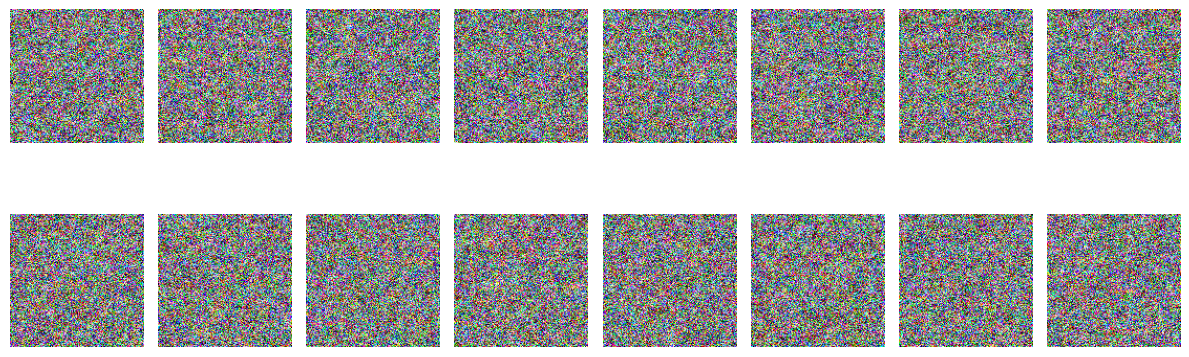

11/11 ━━━━━━━━━━━━━━━━━━━━ 155s 15s/step - loss: 0.0183
Epoch 51/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 689ms/step - loss: 0.0159
Epoch 52/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 705ms/step - loss: 0.0152
Epoch 53/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 679ms/step - loss: 0.0172
Epoch 54/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - loss: 0.0137
Epoch 55/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 757ms/step - loss: 0.0174
Epoch 56/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 683ms/step - loss: 0.0175
Epoch 57/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 698ms/step - loss: 0.0146
Epoch 58/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 683ms/step - loss: 0.0144
Epoch 59/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 691ms/step - loss: 0.0144
Epoch 60/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 678ms/step - loss: 0.0168
Epoch 61/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - loss: 0.0182
Epoch 62/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 769ms/step - loss: 0.0184
Epoch 63/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 684ms/step - loss: 0.0158
Epoch 64/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 679

100%|██████████| 1000/1000 [02:01<00:00,  8.26it/s]


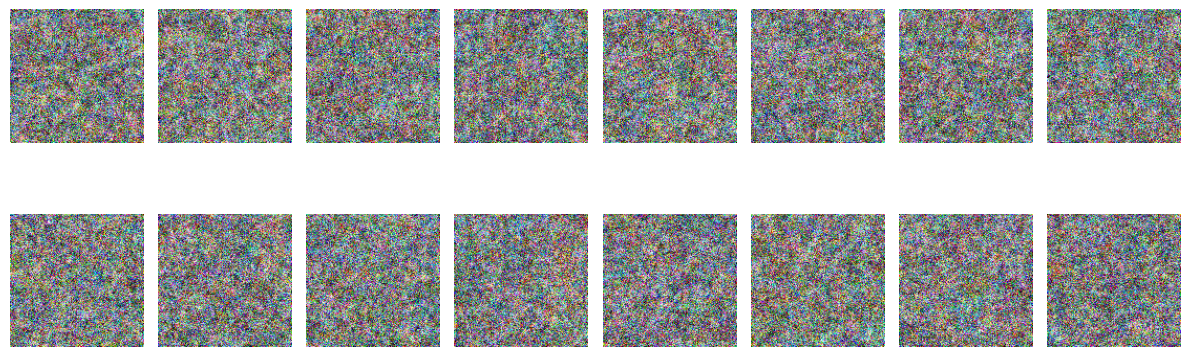

11/11 ━━━━━━━━━━━━━━━━━━━━ 133s 13s/step - loss: 0.0145
Epoch 101/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 703ms/step - loss: 0.0159
Epoch 102/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 715ms/step - loss: 0.0148
Epoch 103/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 704ms/step - loss: 0.0154
Epoch 104/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 731ms/step - loss: 0.0136
Epoch 105/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - loss: 0.0149
Epoch 106/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 696ms/step - loss: 0.0143
Epoch 107/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 687ms/step - loss: 0.0152
Epoch 108/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - loss: 0.0148
Epoch 109/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 720ms/step - loss: 0.0160
Epoch 110/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 688ms/step - loss: 0.0163
Epoch 111/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 695ms/step - loss: 0.0154
Epoch 112/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 685ms/step - loss: 0.0146
Epoch 113/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 683ms/step - loss: 0.0133
Epoch 114/400
11/11 ━━━━━━━━━━━━━

100%|██████████| 1000/1000 [02:00<00:00,  8.32it/s]


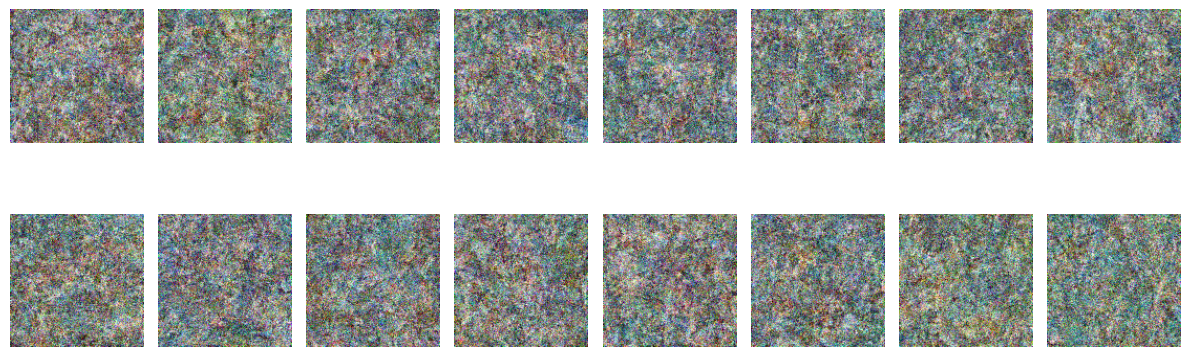

11/11 ━━━━━━━━━━━━━━━━━━━━ 131s 13s/step - loss: 0.0129
Epoch 151/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 690ms/step - loss: 0.0122
Epoch 152/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 692ms/step - loss: 0.0142
Epoch 153/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 698ms/step - loss: 0.0126
Epoch 154/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 699ms/step - loss: 0.0125
Epoch 155/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 688ms/step - loss: 0.0147
Epoch 156/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 690ms/step - loss: 0.0112
Epoch 157/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 696ms/step - loss: 0.0148
Epoch 158/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 696ms/step - loss: 0.0115
Epoch 159/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 695ms/step - loss: 0.0126
Epoch 160/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 693ms/step - loss: 0.0130
Epoch 161/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 691ms/step - loss: 0.0112
Epoch 162/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - loss: 0.0126
Epoch 163/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - loss: 0.0118
Epoch 164/400
11/11 ━━━━━━━━━━━━━

100%|██████████| 1000/1000 [02:00<00:00,  8.33it/s]


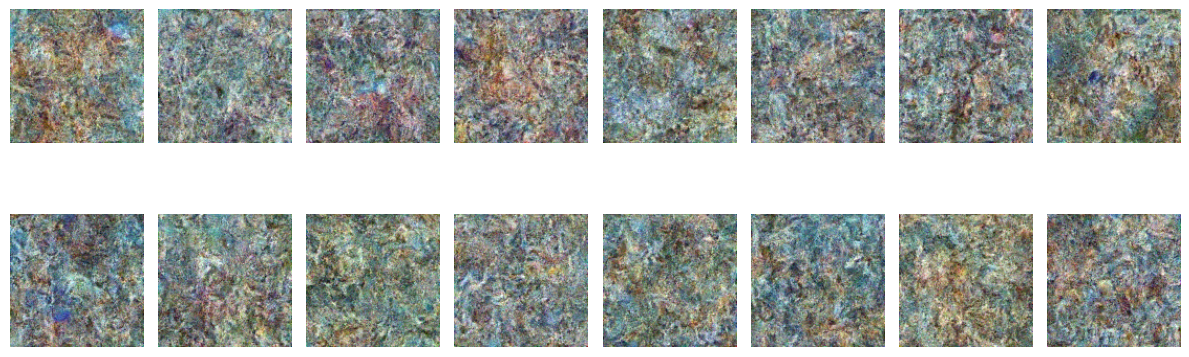

11/11 ━━━━━━━━━━━━━━━━━━━━ 131s 13s/step - loss: 0.0135
Epoch 201/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 700ms/step - loss: 0.0108
Epoch 202/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 693ms/step - loss: 0.0121
Epoch 203/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 705ms/step - loss: 0.0153
Epoch 204/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 685ms/step - loss: 0.0134
Epoch 205/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 697ms/step - loss: 0.0138
Epoch 206/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 715ms/step - loss: 0.0115
Epoch 207/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 694ms/step - loss: 0.0125
Epoch 208/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - loss: 0.0106
Epoch 209/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 687ms/step - loss: 0.0132
Epoch 210/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 683ms/step - loss: 0.0135
Epoch 211/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 691ms/step - loss: 0.0100
Epoch 212/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 693ms/step - loss: 0.0122
Epoch 213/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 730ms/step - loss: 0.0124
Epoch 214/400
11/11 ━━━━━━━━━━━━━

100%|██████████| 1000/1000 [02:05<00:00,  7.97it/s]


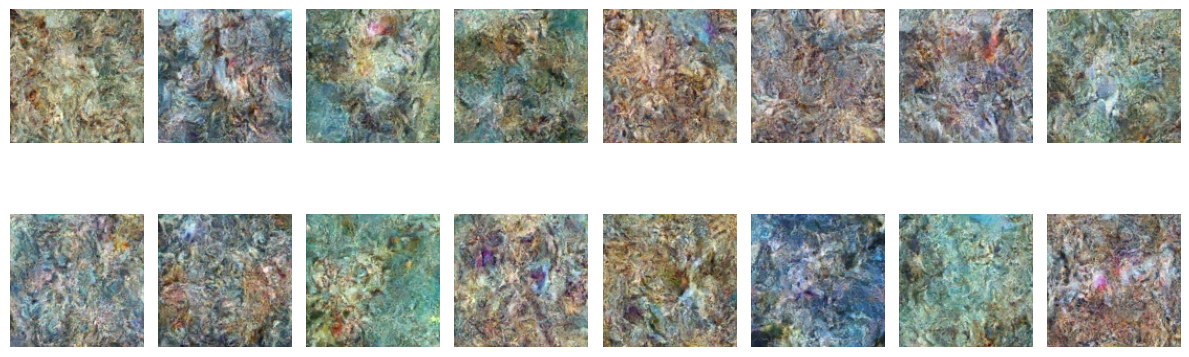

11/11 ━━━━━━━━━━━━━━━━━━━━ 136s 13s/step - loss: 0.0128
Epoch 251/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 685ms/step - loss: 0.0137
Epoch 252/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 695ms/step - loss: 0.0116
Epoch 253/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 673ms/step - loss: 0.0135
Epoch 254/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 812ms/step - loss: 0.0115
Epoch 255/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - loss: 0.0130
Epoch 256/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - loss: 0.0146
Epoch 257/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - loss: 0.0124
Epoch 258/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 670ms/step - loss: 0.0099
Epoch 259/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 684ms/step - loss: 0.0123
Epoch 260/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 703ms/step - loss: 0.0099
Epoch 261/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 700ms/step - loss: 0.0101
Epoch 262/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 745ms/step - loss: 0.0128
Epoch 263/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 690ms/step - loss: 0.0147
Epoch 264/400
11/11 ━━━━━━━━━━━━━

100%|██████████| 1000/1000 [02:03<00:00,  8.08it/s]


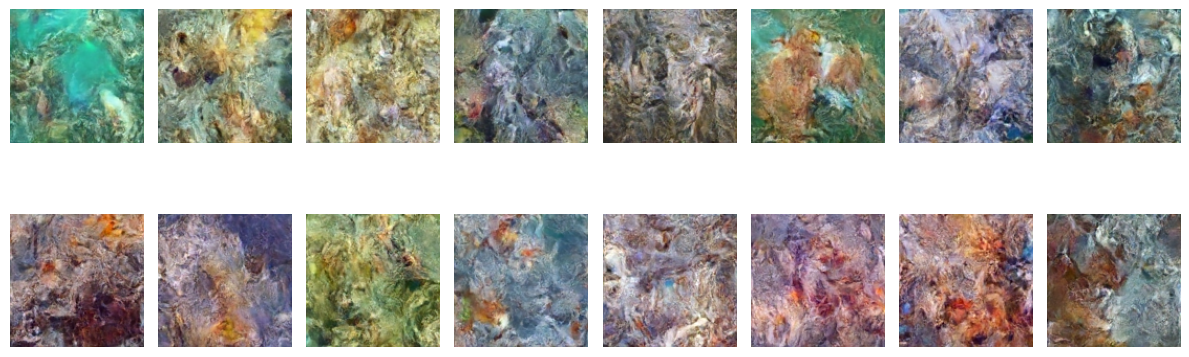

11/11 ━━━━━━━━━━━━━━━━━━━━ 135s 13s/step - loss: 0.0116
Epoch 301/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 693ms/step - loss: 0.0145
Epoch 302/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 903ms/step - loss: 0.0127
Epoch 303/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 684ms/step - loss: 0.0125
Epoch 304/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 685ms/step - loss: 0.0131
Epoch 305/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 693ms/step - loss: 0.0118
Epoch 306/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 711ms/step - loss: 0.0138
Epoch 307/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 699ms/step - loss: 0.0104
Epoch 308/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 696ms/step - loss: 0.0112
Epoch 309/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 692ms/step - loss: 0.0110
Epoch 310/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 706ms/step - loss: 0.0112
Epoch 311/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 708ms/step - loss: 0.0104
Epoch 312/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 698ms/step - loss: 0.0105
Epoch 313/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 691ms/step - loss: 0.0143
Epoch 314/400
11/11 ━━━━━━━━━━━━

100%|██████████| 1000/1000 [02:04<00:00,  8.04it/s]


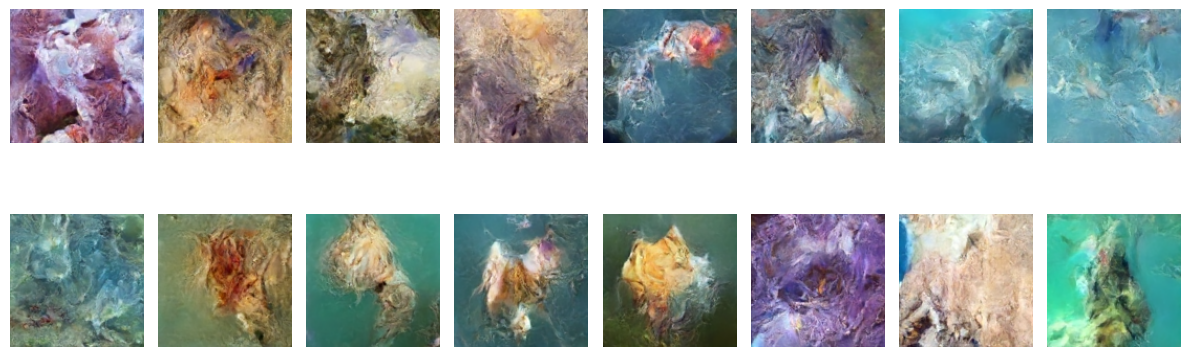

11/11 ━━━━━━━━━━━━━━━━━━━━ 136s 13s/step - loss: 0.0124
Epoch 351/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 687ms/step - loss: 0.0120
Epoch 352/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 687ms/step - loss: 0.0118
Epoch 353/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 692ms/step - loss: 0.0119
Epoch 354/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 709ms/step - loss: 0.0112
Epoch 355/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 730ms/step - loss: 0.0121
Epoch 356/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 704ms/step - loss: 0.0093
Epoch 357/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 703ms/step - loss: 0.0116
Epoch 358/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 701ms/step - loss: 0.0112
Epoch 359/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 696ms/step - loss: 0.0120
Epoch 360/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 693ms/step - loss: 0.0130
Epoch 361/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 701ms/step - loss: 0.0130
Epoch 362/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 690ms/step - loss: 0.0110
Epoch 363/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 685ms/step - loss: 0.0118
Epoch 364/400
11/11 ━━━━━━━━━━━━━

100%|██████████| 1000/1000 [02:03<00:00,  8.10it/s]


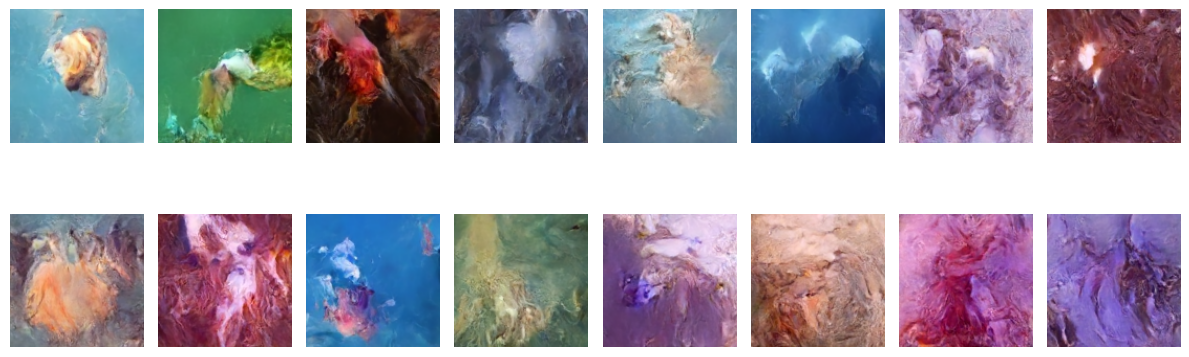

11/11 ━━━━━━━━━━━━━━━━━━━━ 135s 13s/step - loss: 0.0121


In [44]:
# plotting images
class NEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, n):
        super().__init__()
        self._epoch = n # used in modulo below: print & plot every n

    def on_epoch_end(self, epoch, logs=None):
        if epoch > 0 and (epoch + 1) % self._epoch == 0:
            print()
            print(f"Epoch end: {epoch + 1}, plotting...")
            # callbacks have access to their model through self.model
            self.model.plot_images()

plot_every = 50
plot_callback = NEpochLogger(plot_every)

MODELS_DIR = pathlib.Path("models")
MODELS_DIR.mkdir(exist_ok=True)
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    str(MODELS_DIR / "ddpm.weights.h5"),
    monitor="loss",
    save_weights_only=True,
    save_freq=10 # save model every 50 epochs
)

# Train the model
model.fit(
    train_ds,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[plot_callback, ckpt_callback],
)

In [ ]:
# Load the model weights
model.load_weights(MODELS_DIR / "ddpm.weights.h5")

# Generate and plot some samples
model.plot_images(num_rows=4, num_cols=8)

In [ ]:
model.plot_images()

#Save Model


In [45]:
# EXPORT=True

# if EXPORT:
    # unwanted jupyter cache
    # !rm -rf {MODELS_DIR}/.ipynb_checkpoints
    # zip models
!zip ddpm.models.zip {MODELS_DIR}/*
    # connect to drive
    # from google.colab import drive
    # drive.mount('/content/drive/MyDrive/AI')
    # copy zip to drive (adjust folder as needed)
!cp ddpm.models.zip /content/drive/MyDrive/models/

updating: models/ddpm.weights.h5 (deflated 8%)


In [ ]:
# !mkdir generated_samples